# Challenge Markov Chain Monte Carlo

### General Imports

In [1]:
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from preprocess_data import generate_data, visualize_data

In [7]:
dtype = np.float32
data = pd.read_csv("samples_1.csv", index_col = "Unnamed: 0")

def target_log_prob(param):

    '''
    Log density of our gaussian mixture model
    '''

    mu_1, mu_2, sigma_1, sigma_2 = param
    
    log_dens = tf.math.reduce_sum(tf.math.log(
        1/(2*tf.math.sqrt(2*math.pi*sigma_1**2)) * tf.math.exp(-0.5*(data - mu_1)**2/sigma_1**2) + 
        1/(2*tf.math.sqrt(2*math.pi*sigma_2**2)) * tf.math.exp(-0.5*(data - mu_2)**2/sigma_2**2))) - 0.5 * (mu_1**2 + mu_2**2) - (sigma_1 + sigma_2)
    
    return(log_dens)

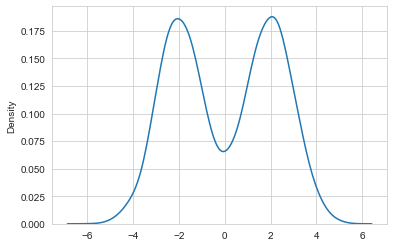

In [8]:
data = generate_data()

visualize_data(data)

### User Inputs

Change Stuff here. To begin leave everything as is.

In [2]:
init_state = dtype([1, 1, 1, 1])
num_samples = 1000
num_burnin = 250
kernel = tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
         target_log_prob_fn=target_log_prob,
         step_size=0.03)

### Generate Samples

This takes some time, in the standard configuration around 40 Seconds on my computer.

In [3]:
#Generate Samples
start_time = time.time()
samples = tfp.mcmc.sample_chain(
    num_results=num_samples,
    current_state=init_state,
    kernel=kernel,
    num_burnin_steps=num_burnin,
    trace_fn=None,
    seed=42)
end_time = time.time()

### Traceplots

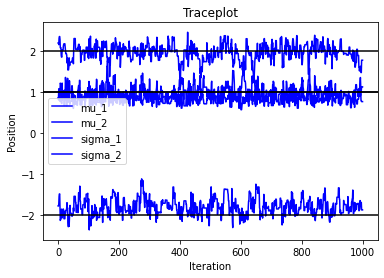

In [4]:
plt.title('Traceplot')
plt.plot(samples.numpy(), 'b')
plt.xlabel('Iteration')
plt.ylabel('Position')
plt.legend(["mu_1", "mu_2", "sigma_1", "sigma_2"])
plt.axhline(y=-2, color='black', linestyle='-')
plt.axhline(y=2, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.axhline(y=1, color='black', linestyle='-')
plt.show()

### Evaluation

In [5]:
sample_mean = tf.reduce_mean(samples, axis=0).numpy()
sample_std = tf.sqrt(
    tf.reduce_mean(
        tf.math.squared_difference(samples, sample_mean),
        axis=0)).numpy()

true_values = [-2, 2, 1, 1]
effective_sample_size = tfp.mcmc.effective_sample_size(samples).numpy()
ESS_mean = round(np.mean(effective_sample_size))
duration_sec = end_time - start_time
Ess_per_sec = round(ESS_mean/duration_sec, 2)


print('Sample Mean:', sample_mean.round(2))
print('Sample Standard Deviation:', sample_std.round(2))
print('True Values:', true_values)
print('Average Effective Sample Size:', ESS_mean)
print('Average ESS per Second:', Ess_per_sec)

Sample Mean: [-1.79  1.96  0.88  0.94]
Sample Standard Deviation: [0.2  0.2  0.16 0.17]
True Values: [-2, 2, 1, 1]
Average Effective Sample Size: 154
Average ESS per Second: 5.22


### Your Turn

Now it's your turn to achieve a better performance by *changing the sampling method*.

To start, think about changing the following:

- *num_burnin*, currently the burnin is very low (check out the trace plot!), how about taking a larger value? Don't forget that taking a too high value negatively impacts performance.
- *init_state*, ideally our chain already starts close to the true values, can you estimate them from the data?

Next up you could work on:

- *kernel*, try the other kernels from the presentation or a completely new Kernel. You can find a list of all TFP kernels [here](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc).
- *hyperparamters*, in the current version we set *step_size = 0.03*, experiment with different values or start looking into [automatic hyperparameter tuning](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/DualAveragingStepSizeAdaptation). Note: Automatic hyperparameter tuning needs an optimal acceptance probability which depends on the kernel.

And if you have lots of time:

- Incorporate prior knowledge by changing the prior distributions. You will need to go into ...